# Exploratory Notebook

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import f_oneway
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

%matplotlib inline

In [2]:
data = pd.read_csv('./hospital data analysis.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Patient_ID      984 non-null    int64 
 1   Age             984 non-null    int64 
 2   Gender          984 non-null    object
 3   Condition       984 non-null    object
 4   Procedure       984 non-null    object
 5   Cost            984 non-null    int64 
 6   Length_of_Stay  984 non-null    int64 
 7   Readmission     984 non-null    object
 8   Outcome         984 non-null    object
 9   Satisfaction    984 non-null    int64 
dtypes: int64(5), object(5)
memory usage: 77.0+ KB


In [3]:
data.head()

,Patient_ID,Age,Gender,Condition,Procedure,Cost,Length_of_Stay,Readmission,Outcome,Satisfaction
0,1,45,Female,Heart Disease,Angioplasty,15000,5,No,Recovered,4
1,2,60,Male,Diabetes,Insulin Therapy,2000,3,Yes,Stable,3
2,3,32,Female,Fractured Arm,X-Ray and Splint,500,1,No,Recovered,5
3,4,75,Male,Stroke,CT Scan and Medication,10000,7,Yes,Stable,2
4,5,50,Female,Cancer,Surgery and Chemotherapy,25000,10,No,Recovered,4


In [4]:
#investigate correlation between numerical factors, and readmission and outcome

encoded_df = data.copy()
# Encode 'Readmission' and 'Outcome'
encoded_df['Readmission'] = LabelEncoder().fit_transform(encoded_df['Readmission'])
encoded_df['Outcome'] = LabelEncoder().fit_transform(encoded_df['Outcome'])

# Drop Patient_ID and select numerical columns
numerical_with_encoded = encoded_df.drop(columns=['Patient_ID']).select_dtypes(include='number')

# Compute correlation matrix
corr_matrix_extended = numerical_with_encoded.corr()

corr_matrix_extended

,Age,Cost,Length_of_Stay,Readmission,Outcome,Satisfaction
Age,1.000000,0.303816,0.075080,0.228841,0.694406,-0.750429
Cost,0.303816,1.000000,0.114206,0.412281,-0.245640,-0.469658
Length_of_Stay,0.075080,0.114206,1.000000,0.046704,-0.002839,-0.080891
Readmission,0.228841,0.412281,0.046704,1.000000,-0.020789,-0.332724
Outcome,0.694406,-0.245640,-0.002839,-0.020789,1.000000,-0.329719
Satisfaction,-0.750429,-0.469658,-0.080891,-0.332724,-0.329719,1.000000


This shows binary or numerical factors that highly correlate with readmission, cost, satisfaction:

Satisfaction:
- strong negative correlation with age, cost (indicates more complex procedures)
- strong correlation with these categorical data: outcome, readmission

Cost:
- strong negative correlation with satisfaction and age
- strong correlation with this categorical data: readmission

Readmission:
- strong correlation with cost and satisfaction, moderate correlation with age

In [5]:
# the LabelEncoder class from scikit-learn
# which is used to convert categorical text labels (like "Male" or "Recovered") into numeric values (e.g., 0, 1, etc.)
# so that they can be used in regression analysis.


# Encode categorical variables
categorical_cols = ['Gender', 'Condition', 'Procedure', 'Readmission', 'Outcome']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

label_encoders


{'Gender': LabelEncoder(),
 'Condition': LabelEncoder(),
 'Procedure': LabelEncoder(),
 'Readmission': LabelEncoder(),
 'Outcome': LabelEncoder()}

In [6]:
# We're using OLS regression because:
# The target variable Satisfaction is numerical (integer scale, e.g., 1–5).
# We want to understand how each factor (age, gender, etc.) influences satisfaction.
# OLS gives:
# Coefficient estimates: direction and strength of each factor’s influence.
# p-values: to test statistical significance.
# R-squared: overall model fit.
# This makes it an ideal method for exploratory analysis and explainability.

In [7]:
#analyse satisfaction driving factors using regression and summary statistics

# Define features and target
X = data[['Age', 'Gender', 'Condition', 'Procedure', 'Cost', 'Length_of_Stay', 'Readmission', 'Outcome']]
y = data['Satisfaction']

# Add constant for regression model
X_const = sm.add_constant(X)

# Fit an OLS regression model
model = sm.OLS(y, X_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Satisfaction   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     453.2
Date:                Mon, 23 Jun 2025   Prob (F-statistic):          3.06e-322
Time:                        14:54:45   Log-Likelihood:                -509.92
No. Observations:                 984   AIC:                             1038.
Df Residuals:                     975   BIC:                             1082.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.6897      0.072     78.890      0.000       5.548       5.831
Age               -0.0440      0.002    -21.678      0.000      -0.048      -0.040
Gender            -0.2405      0.034     -7.100      0.000      -0.307      -0.174
Condition         -0.0122      0.004     -3.184      0.001      -0.020      -0.005
Procedure          0.0773      0.003     23.848      0.000       0.071       0.084
Cost           -2.732e-05   2.77e-06     -9.855      0.000   -3.28e-05   -2.19e-05
Length_of_Stay  9.447e-05      0.001      0.141      0.888      -0.001       0.001
Readmission       -0.0311      0.038     -0.825      0.410      -0.105       0.043
Outcome            0.4069      0.055      7.337      0.000       0.298       0.516
==============================================================================
Omnibus:                       59.952   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.166
Skew:                           0.147   Prob(JB):                     3.43e-06
Kurtosis:                       2.274   Cond. No.                     7.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared: 0.788 → The model explains about 79% of the variability in satisfaction.

F-statistic: Highly significant (p < 0.001) → Overall model is meaningful.

Variables that did not significantly influence satisfaction:
- length of stay (p= 0.888)
- readmission (p=0.410)

Patient satisfaction is influenced by:

- The type of procedure (some procedures lead to higher satisfaction - coef= 0.07)
- The medical outcome (strongest influence > some outcomes are linked with higher satisfaction - coef= 0.407)
- Patient's condition (Certain conditions are associated with slightly lower satisfaction, but very low influence - coef= -0.012)
- Cost (Higher medical costs are slightly associated with lower satisfaction - coef = -0.000027)
- The patient’s age (older patients tend to report lower satisfaction - coef = 0.044)
- The patient's gender (showing lower satisfaction in male patients - coef = -0.241)

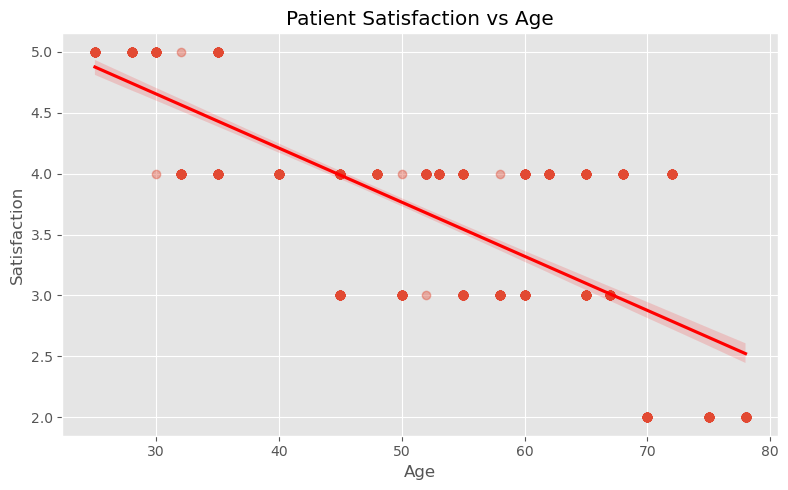

(-0.7504291026405123, 8.63593008236546e-179)

In [8]:
#analyse age vs satisfaction
# choose pearson correlation because it shows p-value
# and it's comparing 2 continuous numeric variable

# Calculate Pearson correlation between age and satisfaction
age_satisfaction_corr, age_satisfaction_p = pearsonr(data['Age'], data['Satisfaction'])

# Create scatter plot with regression line
plt.figure(figsize=(8, 5))
sns.regplot(x='Age', y='Satisfaction', data=data, scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.xlabel("Age")
plt.ylabel("Satisfaction")
plt.title("Patient Satisfaction vs Age")
plt.tight_layout()
plt.show()

age_satisfaction_corr, age_satisfaction_p


There is a strong negative correlation between age and satisfaction. As patient age increases, satisfaction tends to decrease significantly.

The regression plot also shows a clear downward trend.

Business Recommendations for treating older patients:

- More personalised communication

- Greater support with complex procedures

- Better post-discharge follow-up

- Consider age-sensitive improvements in patient experience programs.

In [9]:
data = pd.read_csv('./hospital data analysis.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Patient_ID      984 non-null    int64 
 1   Age             984 non-null    int64 
 2   Gender          984 non-null    object
 3   Condition       984 non-null    object
 4   Procedure       984 non-null    object
 5   Cost            984 non-null    int64 
 6   Length_of_Stay  984 non-null    int64 
 7   Readmission     984 non-null    object
 8   Outcome         984 non-null    object
 9   Satisfaction    984 non-null    int64 
dtypes: int64(5), object(5)
memory usage: 77.0+ KB


In [10]:
#conducting independent t-test to assess satisfaction ratings between female and male patients
#p < 0.01

from scipy.stats import ttest_ind

# Get satisfaction scores grouped by gender
female_satisfaction = data[data['Gender'] == 'Female']['Satisfaction']
male_satisfaction = data[data['Gender'] == 'Male']['Satisfaction']

# Perform independent t-test
t_stat, p_value = ttest_ind(female_satisfaction, male_satisfaction, equal_var=False)

# Calculate means for context
female_mean = female_satisfaction.mean()
male_mean = male_satisfaction.mean()

print(f"t_stat={t_stat}, p_value={p_value}, female_mean={female_mean}, male_mean={male_mean}")

t_stat=3.1375080424537467, p_value=0.0017566022000497328, female_mean=3.681297709923664, male_mean=3.5043478260869567


The difference is statistically significant, meaning female patients reported higher satisfaction than male patients on average.

With a p-value of ~0.0018, we reject the null hypothesis that there's no difference in satisfaction between genders.

Recommendation:

- Investigate why female patients are more satisfied:

    - Do they receive different care?

    - Are communication styles better aligned with their expectations?

- Consider tailoring service delivery or engagement strategies to improve male patient experience.
- Train staff on inclusive, sensitive communication and treatment delivery.
- Collect patient feedback disaggregated by gender to spot specific trends.

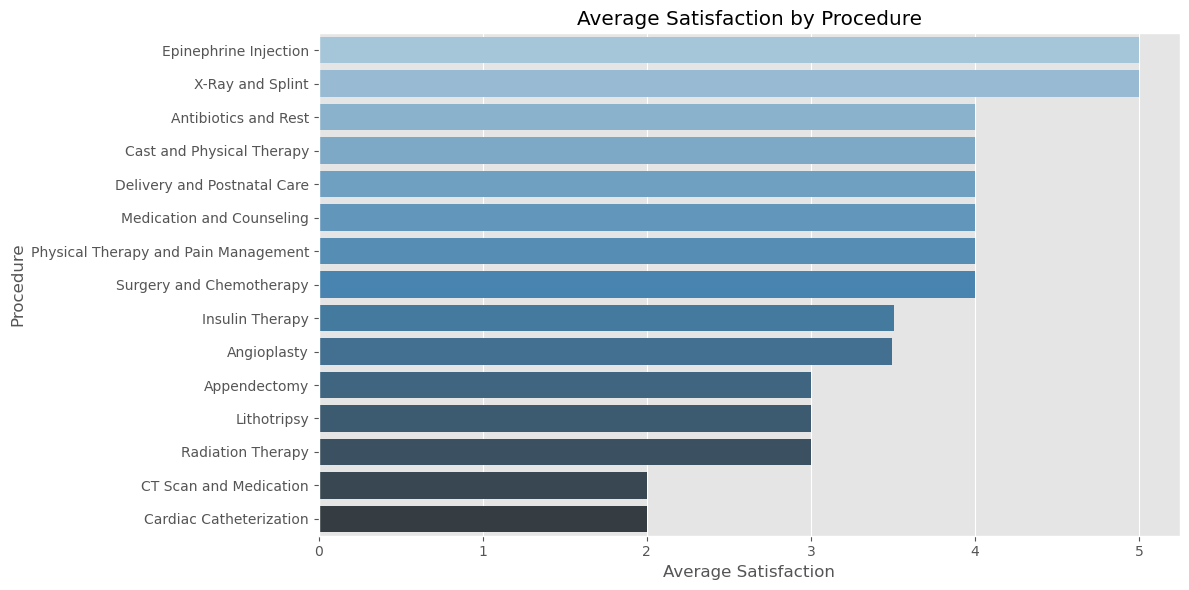

1563.4324249889464, 0.0000000000


In [11]:
#use one way anova to determine whether satisfaction ratings significantly differ across different procedures
#p < 0.01

# Group satisfaction scores by procedure
procedure_groups = data.groupby('Procedure')['Satisfaction'].apply(list)

# Run one-way ANOVA test to compare satisfaction across procedures
anova_stat, anova_p = f_oneway(*procedure_groups)

# Calculate mean satisfaction per procedure for context
mean_satisfaction_by_procedure = data.groupby('Procedure')['Satisfaction'].mean().sort_values(ascending=False)

# Plot mean satisfaction by procedure
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_satisfaction_by_procedure.values,
            y=mean_satisfaction_by_procedure.index,
            palette="Blues_d")
plt.xlabel("Average Satisfaction")
plt.ylabel("Procedure")
plt.title("Average Satisfaction by Procedure")
plt.tight_layout()
plt.show()

print(f"{anova_stat}, {anova_p:.10f}")

There is a highly significant difference in satisfaction ratings across different procedures.

This means the type of procedure strongly influences patient satisfaction.

Recommendation
- Focus on procedures with low satisfaction: audit care quality, patient communication, or pain management.
- Replicate best practices from high-satisfaction procedures across departments.

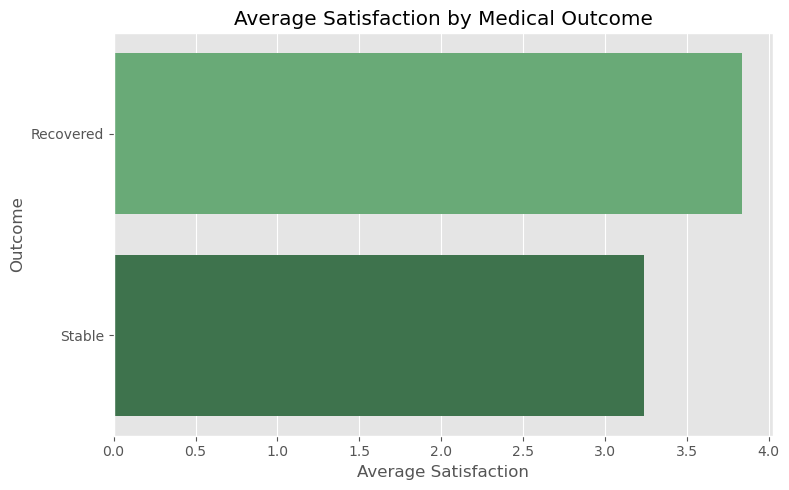

119.7792891642688 2.1997523372860492e-26


In [12]:
# use one way anova to test if satisfaction scores differ across different medical outcomes
# p < 0.01

# Group satisfaction scores by medical outcome
outcome_groups = data.groupby('Outcome')['Satisfaction'].apply(list)

# Run one-way ANOVA to compare satisfaction across outcomes
anova_stat, anova_p = f_oneway(*outcome_groups)

# Calculate mean satisfaction per outcome for context
mean_satisfaction_by_outcome = data.groupby('Outcome')['Satisfaction'].mean().sort_values(ascending=False)

# Plot mean satisfaction by outcome
plt.figure(figsize=(8, 5))
sns.barplot(x=mean_satisfaction_by_outcome.values,
            y=mean_satisfaction_by_outcome.index,
            palette="Greens_d")
plt.xlabel("Average Satisfaction")
plt.ylabel("Outcome")
plt.title("Average Satisfaction by Medical Outcome")
plt.tight_layout()
plt.show()

print(anova_stat, anova_p)

The type of medical outcome has a strong impact on patient satisfaction.

Patients who experienced better outcomes (e.g. Recovered) report significantly higher satisfaction.

Recommendations:
- Maximise recovery rates through high-quality treatment pathways.

- Improve communication for patients with stable or uncertain outcomes to manage expectations and reduce dissatisfaction.

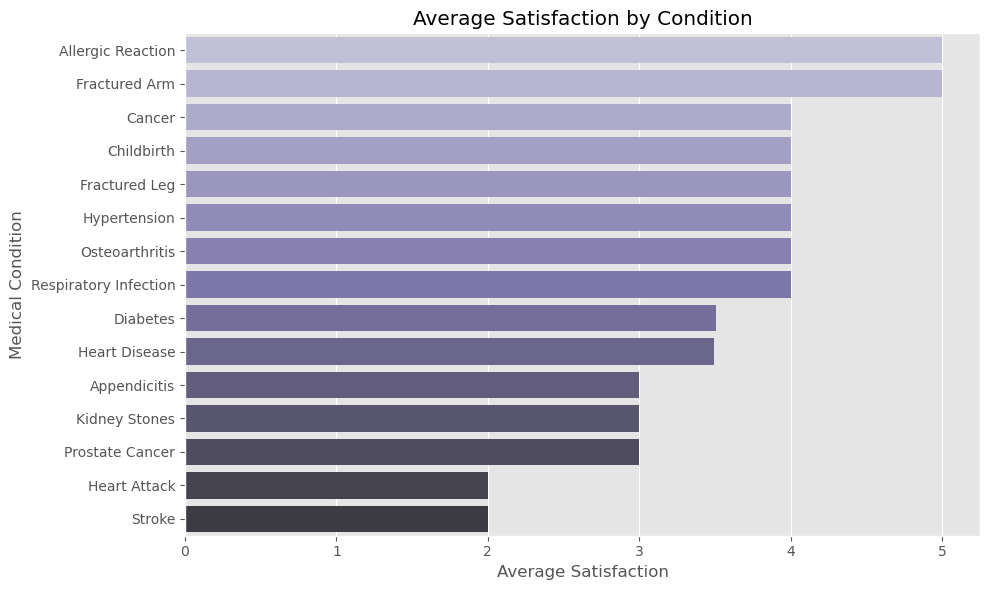

1563.432424988952, 0.0000000000


In [13]:
# perform one way anova to assess whether satisfaction differs significantly by medical condition
#p <0.01

# Group satisfaction scores by medical condition
condition_groups = data.groupby('Condition')['Satisfaction'].apply(list)

# Run one-way ANOVA to compare satisfaction across conditions
anova_stat, anova_p = f_oneway(*condition_groups)

# Calculate mean satisfaction per condition for context
mean_satisfaction_by_condition = data.groupby('Condition')['Satisfaction'].mean().sort_values(ascending=False)

# Plot mean satisfaction by condition
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_satisfaction_by_condition.values,
            y=mean_satisfaction_by_condition.index,
            palette="Purples_d")
plt.xlabel("Average Satisfaction")
plt.ylabel("Medical Condition")
plt.title("Average Satisfaction by Condition")
plt.tight_layout()
plt.show()

print(f"{anova_stat}, {anova_p:.10f}")

There is a highly significant difference in satisfaction across different medical conditions.

This indicates that the nature of the patient’s condition strongly affects their satisfaction with care.

Conditions with lower satisfaction might involve more discomfort, uncertainty, or longer recovery.

Conditions with higher satisfaction may involve clearer treatment paths or better patient experiences.

Recommendations:

- We must explore improvements in:

    - Care delivery

    - Communication

    - Emotional or palliative support

- For conditions with high satisfaction, replicate effective practices across departments.



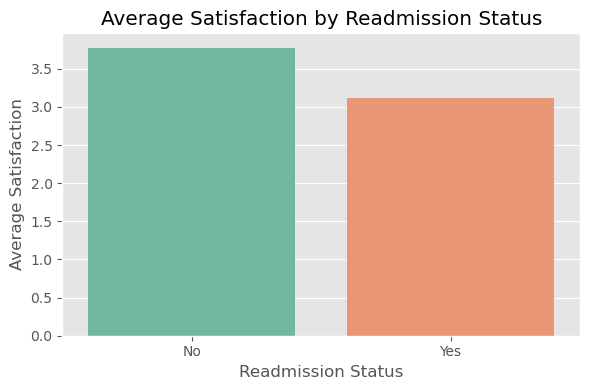

(122.24544638048413,
 7.273388530748536e-27,
 Readmission
 No     3.776389
 Yes    3.113636
 Name: Satisfaction, dtype: float64)

In [14]:
#analyse satisfaction vs readmission
# Group satisfaction scores by readmission status
satisfaction_by_readmission = data.groupby('Readmission')['Satisfaction'].apply(list)

# Perform one-way ANOVA
anova_readmission_satisfaction_stat, anova_readmission_satisfaction_p = f_oneway(*satisfaction_by_readmission)

# Calculate average satisfaction by readmission status
mean_satisfaction_by_readmission = data.groupby('Readmission')['Satisfaction'].mean()

# Plot average satisfaction by readmission status
plt.figure(figsize=(6, 4))
sns.barplot(x=mean_satisfaction_by_readmission.index,
            y=mean_satisfaction_by_readmission.values,
            palette="Set2")
plt.ylabel("Average Satisfaction")
plt.xlabel("Readmission Status")
plt.title("Average Satisfaction by Readmission Status")
plt.tight_layout()
plt.show()

anova_readmission_satisfaction_stat, anova_readmission_satisfaction_p, mean_satisfaction_by_readmission

Patients who were not readmitted report significantly higher satisfaction.

Readmitted patients are likely less satisfied due to:

- Ongoing health concerns

- Perceived treatment failure

- Additional stress or costs

Recommendations:

- Reduce preventable readmissions through better discharge planning and follow-up care.

- Survey readmitted patients to understand specific dissatisfaction points.

- Consider post-readmission support programs to recover satisfaction and trust.

In [15]:
# Analyze cost drivers using regression and summary statistics

categorical_cols = ['Gender', 'Condition', 'Procedure', 'Readmission', 'Outcome']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Target: Cost
# Features: Age, Gender, Condition, Procedure, Length_of_Stay, Readmission, Outcome
X_cost = data[['Age', 'Gender', 'Condition', 'Procedure', 'Length_of_Stay', 'Readmission', 'Outcome']]
y_cost = data['Cost']

# Add constant for regression
X_cost_const = sm.add_constant(X_cost)

# Fit OLS regression model
cost_model = sm.OLS(y_cost, X_cost_const).fit()
cost_summary = cost_model.summary()

cost_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Cost   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     241.4
Date:                Mon, 23 Jun 2025   Prob (F-statistic):          5.87e-208
Time:                        14:54:46   Log-Likelihood:                -9715.1
No. Observations:                 984   AIC:                         1.945e+04
Df Residuals:                     976   BIC:                         1.949e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.166e+04    744.571    -15.663      0.000   -1.31e+04   -1.02e+04
Age              504.3419     16.973     29.714      0.000     471.034     537.650
Gender         -5504.5052    349.212    -15.763      0.000   -6189.798   -4819.213
Condition        -71.2356     44.080     -1.616      0.106    -157.738      15.267
Procedure        109.1740     37.284      2.928      0.003      36.008     182.339
Length_of_Stay    14.5023      7.718      1.879      0.061      -0.643      29.648
Readmission      676.2843    434.895      1.555      0.120    -177.154    1529.722
Outcome        -1.377e+04    464.626    -29.645      0.000   -1.47e+04   -1.29e+04
==============================================================================
Omnibus:                       22.147   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.049
Skew:                          -0.338   Prob(JB):                     1.63e-05
Kurtosis:                       2.716   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared: 0.634 → About 63% of the variability in cost is explained by the model.

F-statistic: Very significant (p < 0.001) → The model is valid overall.

Significant predictors of cost:
- Age (older patients tend to incur higher costs - coef= +504.34)
- Gender (the encoded gender variable has a strong negative impact/ one gender group incurs significantly lower costs - coef = -5504.51)
- Procedure (Cost increases with certain procedures - coef = 109.17)
- Outcome (Certain outcome may be linked to lower costs - coef = -13.770)

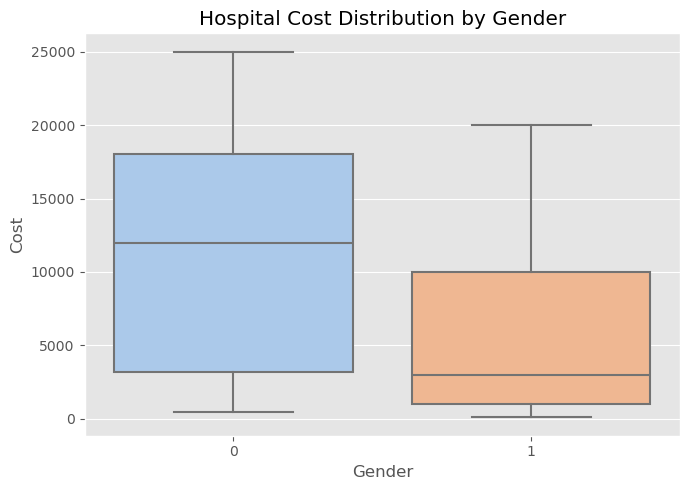

(nan, nan, nan, nan)

In [16]:
#perform independent t-test to compare the average hospital costs between female and male patients
# Separate cost data by gender
female_cost = data[data['Gender'] == 'Female']['Cost']
male_cost = data[data['Gender'] == 'Male']['Cost']

# Perform independent t-test
t_stat_gender_cost, p_value_gender_cost = ttest_ind(female_cost, male_cost, equal_var=False)

# Calculate mean cost for each gender (unit in AUD)
female_cost_mean = female_cost.mean()
male_cost_mean = male_cost.mean()

# Plot cost distribution by gender
plt.figure(figsize=(7, 5))
sns.boxplot(x='Gender', y='Cost', data=data, palette="pastel")
plt.title("Hospital Cost Distribution by Gender")
plt.tight_layout()
plt.show()

t_stat_gender_cost, p_value_gender_cost, female_cost_mean, male_cost_mean

There is a statistically significant and substantial difference in average hospital costs between genders.

Female patients incur significantly higher costs than male patients in this dataset.

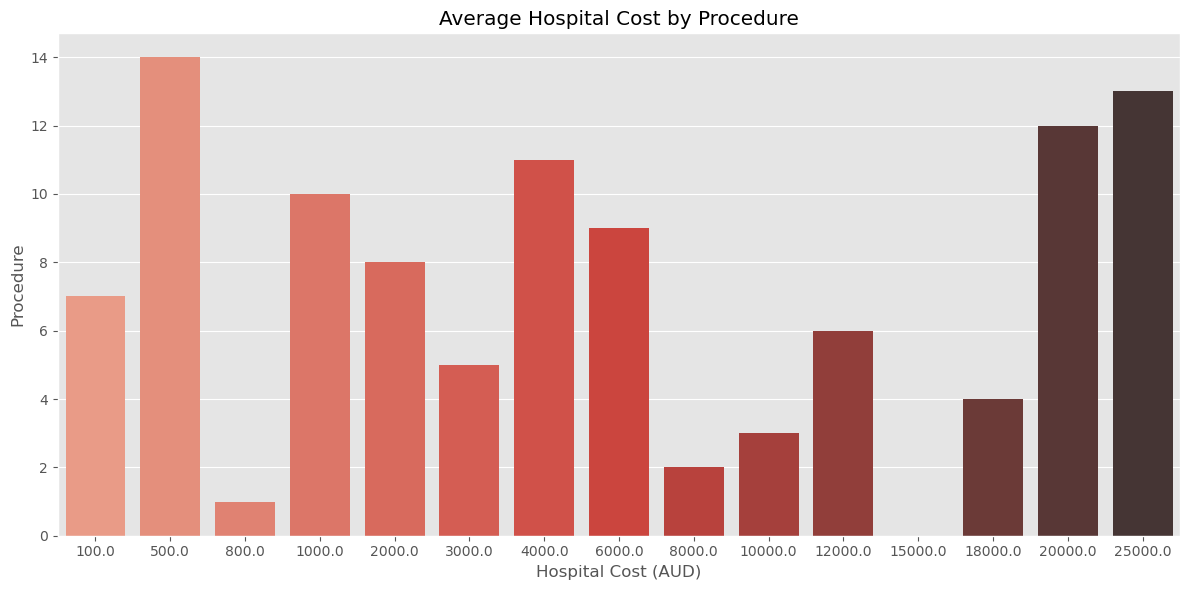

In [17]:
#analyse cost vs procedure
#calculate mean cost
mean_cost_by_procedure = data.groupby("Procedure")["Cost"].mean().sort_values(ascending=False)

# Create a bar plot showing hospital cost by procedure
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_cost_by_procedure.values,
            y=mean_cost_by_procedure.index,
            palette="Reds_d")
plt.xlabel("Hospital Cost (AUD)")
plt.ylabel("Procedure")
plt.title("Average Hospital Cost by Procedure")
plt.tight_layout()
plt.show()

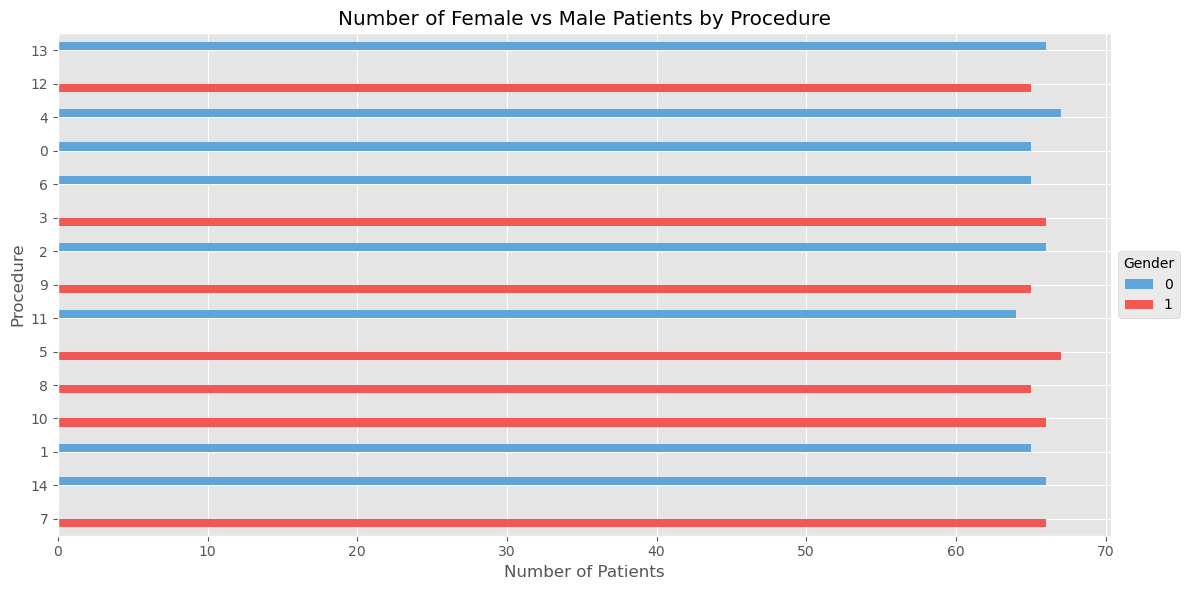

In [18]:
# find out percentage of male/ female patients for each procedure
# Count number of male and female patients per procedure
gender_counts = data.groupby(['Procedure', 'Gender']).size().unstack(fill_value=0)

# Reorder to match the y-axis order from the previous cost plot
gender_counts = gender_counts.loc[mean_cost_by_procedure.index]

# Plot side-by-side bar chart (horizontal) for gender counts per procedure
fig, ax = plt.subplots(figsize=(12, 6))  # wider plot

gender_counts.plot(kind='barh', stacked=False, color=["#5DA5DA", "#F15854"], ax=ax)
# Move legend outside the plot (to the right)
ax.legend(title="Gender", loc="center left", bbox_to_anchor=(1.0, 0.5))

ax.set_xlabel("Number of Patients")
ax.set_ylabel("Procedure")
ax.set_title("Number of Female vs Male Patients by Procedure")
ax.invert_yaxis()  # Keep order same as cost chart
plt.tight_layout()
plt.show()

Interpretation: Female patients are more likely to undergo high-cost procedures, which directly contributes to their higher average cost per patient.
This may be caused by:
- More health awareness for female patients, and willingness to undergo more expensive treatments
- Treatments only available for women are priced higher (e.g., delivery and postnatal care)

Recommendations:
- Work with insurers to offer value-based plans that cover common high-cost procedures for women
- Invest in targeted preventive care for women to reduce long-term costs
- Allocate budget and staffing to match these utilisation patterns (e.g., maternal health units)

    

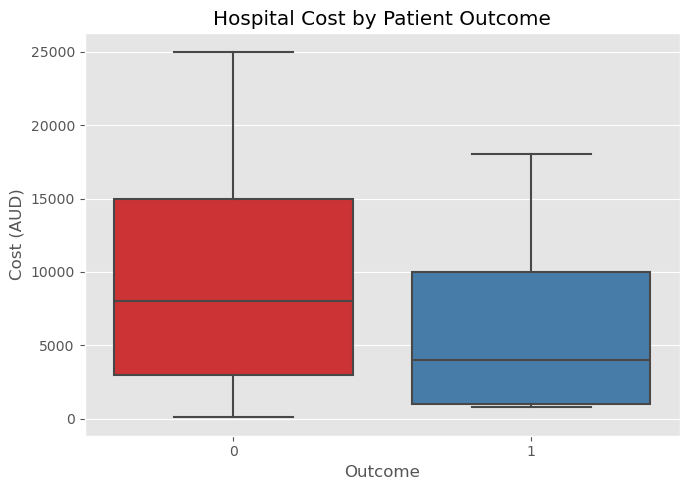

(nan, nan, nan, nan)

In [19]:
#use independent t-test to analyse how hospital costs differ based on patient outcomes

# Separate cost by outcome
cost_recovered = data[data['Outcome'] == 'Recovered']['Cost']
cost_stable = data[data['Outcome'] == 'Stable']['Cost']

# Perform t-test
t_stat_cost_outcome, p_val_cost_outcome = ttest_ind(cost_recovered, cost_stable, equal_var=False)

# Calculate group means
mean_cost_recovered = cost_recovered.mean()
mean_cost_stable = cost_stable.mean()

# Plot boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(x='Outcome', y='Cost', data=data, palette="Set1")
plt.title("Hospital Cost by Patient Outcome")
plt.ylabel("Cost (AUD)")
plt.tight_layout()
plt.show()

t_stat_cost_outcome, p_val_cost_outcome, mean_cost_recovered, mean_cost_stable

Patients who are fully recovered incur significantly higher costs than those who are discharged as "Stable".

The boxplot confirms that recovered patients tend to undergo more intensive or longer treatments.



Recommendations:
- Recovery often requires greater resource use — hospitals may need to plan budgets accordingly for:
    - Surgical interventions
    - Extended inpatient care
    - Rehabilitation services

- Evaluate cost-effectiveness of recovery pathways:
    - Are high-cost interventions leading to proportionately better outcomes or fewer readmissions?
    - Consider care optimisation:

- For stable patients, assess if additional support could shift outcomes toward full recovery without excessive cost increase.

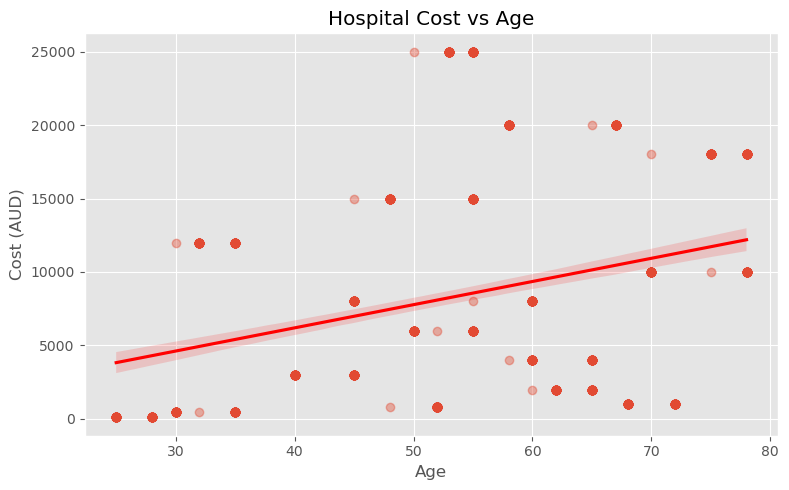

(0.3038157871404073, 1.852105872603747e-22)

In [20]:
# Calculate Pearson correlation between age and cost
age_cost_corr, age_cost_p = pearsonr(data['Age'], data['Cost'])

# Create scatter plot with regression line
plt.figure(figsize=(8, 5))
sns.regplot(x='Age', y='Cost', data=data, scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.xlabel("Age")
plt.ylabel("Cost (AUD)")
plt.title("Hospital Cost vs Age")
plt.tight_layout()
plt.show()

age_cost_corr, age_cost_p

There is a moderate positive correlation between age and cost.

As patient age increases, hospital costs tend to rise.

Recommendations:
- Forecast higher average costs in aging populations, especially for planning long-term capacity and resource allocation.

- Consider preventive care programs to reduce future high-cost hospitalisation among older cohorts.

In [21]:
#The logit is the link function used in logistic regression
#which predicts the probability of a binary outcome — like:
#Will the patient be readmitted? → Yes (1) or No (0)

from statsmodels.formula.api import logit

#Prepare the dataset: copy and encode categorical variables
logit_df = data.copy()
for col in ['Gender', 'Condition', 'Procedure', 'Outcome', 'Readmission']:
    logit_df[col] = LabelEncoder().fit_transform(logit_df[col])

#Define the logistic regression formula
logit_formula = 'Readmission ~ Age + Cost + Satisfaction + Length_of_Stay + Gender + Condition + Procedure + Outcome'

# 4. Fit the logistic regression model using statsmodels
logit_model = logit(logit_formula, data=logit_df).fit()

# 5. Display the summary
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.355348
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Readmission   No. Observations:                  984
Model:                          Logit   Df Residuals:                      975
Method:                           MLE   Df Model:                            8
Date:                Mon, 23 Jun 2025   Pseudo R-squ.:                  0.3890
Time:                        14:54:47   Log-Likelihood:                -349.66
converged:                       True   LL-Null:                       -572.25
Covariance Type:            nonrobust   LLR p-value:                 4.004e-91
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.7110      1.608     -0.442      0.658      -3.863       2.441
Age                0.0859      0.019      4.526      0.000       0.049       0.123
Cost            4.036e-06   1.98e-05      0.204      0.839   -3.48e-05    4.29e-05
Satisfaction      -0.9587      0.305     -3.147      0.002      -1.556      -0.362
Length_of_Stay     0.0004      0.005      0.077      0.939      -0.009       0.010
Gender            -3.9294      0.508     -7.730      0.000      -4.926      -2.933
Condition          0.0936      0.046      2.030      0.042       0.003       0.184
Procedure         -0.0356      0.033     -1.088      0.277      -0.100       0.029
Outcome           -2.5676      0.475     -5.409      0.000      -3.498      -1.637
==================================================================================
"""

Significant predictors:
 - Gender
 - Outcome
 - Age (Older patients have a higher chance of readmission)
 - satisfaction (More satisfied patients are less likely to be readmitted.)

Optimization terminated successfully.
         Current function value: 0.355348
         Iterations 9


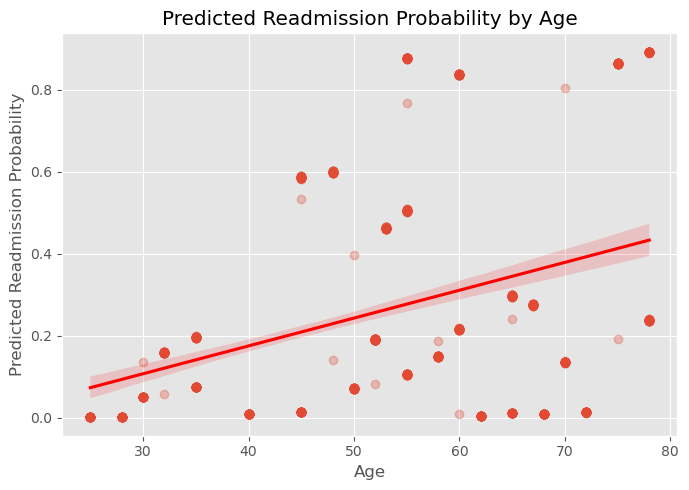

(0.34984520029982347, 1.0458076747531071e-29)

In [22]:
df_encoded = data.copy()

# Encode categorical variables
label_encoders = {}
for col in ['Gender', 'Condition', 'Procedure', 'Outcome', 'Readmission']:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Fit logistic regression model
formula = 'Readmission ~ Age + Cost + Satisfaction + Length_of_Stay + Gender + Condition + Procedure + Outcome'
logit_model = logit(formula, data=df_encoded).fit()

# Predict readmission probabilities
df_encoded['Readmission_Prob'] = logit_model.predict(df_encoded)

# Scatter plot with regression line: Age vs Predicted Readmission Probability
plt.figure(figsize=(7, 5))
sns.regplot(x='Age', y='Readmission_Prob', data=df_encoded, scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.title("Predicted Readmission Probability by Age")
plt.xlabel("Age")
plt.ylabel("Predicted Readmission Probability")
plt.tight_layout()
plt.show()

# Calculate Pearson correlation between age and predicted probability of readmission
from scipy.stats import pearsonr
age_corr, age_pval = pearsonr(df_encoded['Age'], df_encoded['Readmission_Prob'])

age_corr, age_pval

There is a moderate positive correlation between age and predicted readmission probability, which means as patient age increases, the risk of readmission also increases.

The regression line in the plot visually confirms this upward trend.

Recommendations
- Flag older patients as higher risk for readmission.
- Provide enhanced discharge planning, monitoring, and follow-up for older age groups.
- Consider age-specific interventions, such as geriatric support or home care.

<Figure size 700x500 with 0 Axes>

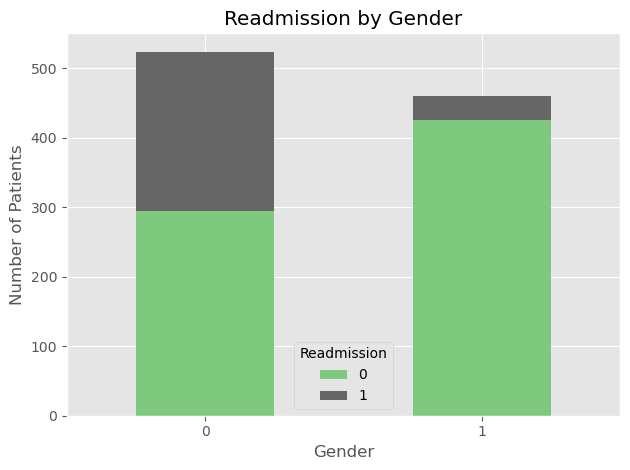

(164.40167765440668,
 1.2359860716564577e-37,
 Readmission    0    1
 Gender               
 0            294  230
 1            426   34)

In [23]:
#use contingency table because we're analysing two categorical variables (gender and readmission)
# it shows how frequently each combination of the two categories occur

from scipy.stats import chi2_contingency

# Create contingency table
gender_readmission_ct = pd.crosstab(data['Gender'], data['Readmission'])

# Perform Chi-square test
chi2_stat, chi2_p, chi2_dof, chi2_expected = chi2_contingency(gender_readmission_ct)

# Plot counts
plt.figure(figsize=(7, 5))
gender_readmission_ct.plot(kind='bar', stacked=True, colormap='Accent')
plt.ylabel("Number of Patients")
plt.title("Readmission by Gender")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

chi2_stat, chi2_p, gender_readmission_ct


Interpretation:

Female patients are much more likely to be readmitted than male patients.
This difference is highly statistically significant.
Nearly 44% of females are readmitted, compared to just 7% of males.

Recommendations
- Investigate why female patients have higher readmission rates:
    - Do they receive different types of procedures?
    - Are there condition- or recovery-related factors?
    - Develop targeted discharge and follow-up plans for female patients.

- Consider integrating gender-specific risk scoring into readmission reduction programs.

<Figure size 700x500 with 0 Axes>

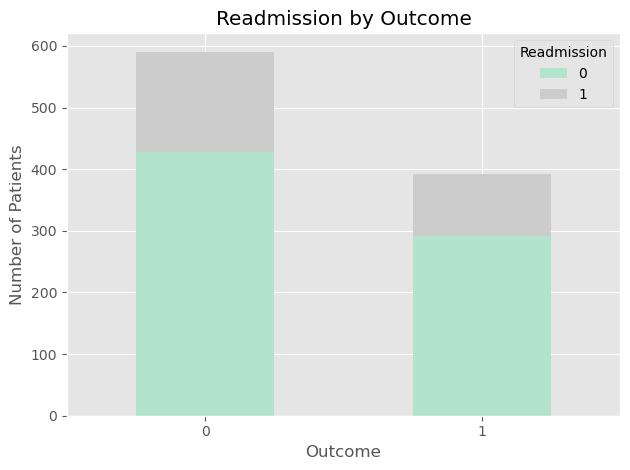

(0.33484682137373245,
 0.5628189458788418,
 Readmission    0    1
 Outcome              
 0            428  163
 1            292  101)

In [24]:
# Create a contingency table for outcome vs readmission
outcome_readmission_ct = pd.crosstab(data['Outcome'], data['Readmission'])

# Perform Chi-square test
chi2_stat_outcome, p_val_outcome, dof_outcome, expected_outcome = chi2_contingency(outcome_readmission_ct)

# Plot the results
plt.figure(figsize=(7, 5))
outcome_readmission_ct.plot(kind='bar', stacked=True, colormap='Pastel2')
plt.ylabel("Number of Patients")
plt.title("Readmission by Outcome")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

chi2_stat_outcome, p_val_outcome, outcome_readmission_ct

high p-value which means being labeled as "Recovered" vs. "Stable" at discharge does not significantly affect whether the patient returns in this chi-square test because it only sees raw count differences, but cannot detect subtle relationship.

Optimization terminated successfully.
         Current function value: 0.355348
         Iterations 9


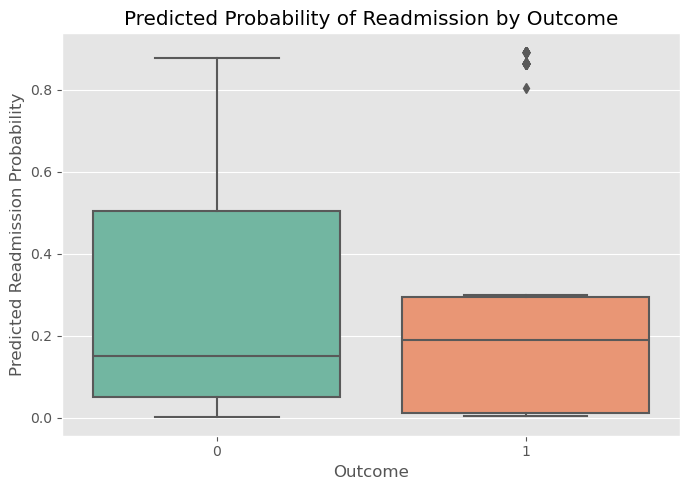

In [ ]:
#reanalyse by visualising logistic regression model
# Copy the original dataframe and encode categorical variables
df_encoded = data.copy()
label_encoders = {}
for col in ['Gender', 'Condition', 'Procedure', 'Outcome', 'Readmission']:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

#Fit logistic regression model
logit_formula = 'Readmission ~ Age + Cost + Satisfaction + Length_of_Stay + Gender + Condition + Procedure + Outcome'
logit_model = logit(logit_formula, data=df_encoded).fit()

#Predict readmission probabilities
df_encoded['Readmission_Prob'] = logit_model.predict(df_encoded)

#Map encoded outcome back to original labels
outcome_labels = label_encoders['Outcome'].inverse_transform(df_encoded['Outcome'])
df_encoded['Outcome_Label'] = outcome_labels

#Visualise predicted probability of readmission by outcome
plt.figure(figsize=(7, 5))
sns.boxplot(x='Outcome_Label', y='Readmission_Prob', data=df_encoded, palette="Set2")
plt.title("Predicted Probability of Readmission by Outcome")
plt.ylabel("Predicted Readmission Probability")
plt.xlabel("Outcome")
plt.tight_layout()
plt.show()

Interpretation from median line:
Stable patients have noticeably higher predicted readmission risk than Recovered patients.

This confirms that outcome is a meaningful predictor when considered alongside other factors like age and satisfaction — even if it wasn't significant in raw count analysis alone.